In [12]:
import os
import glob
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

os.makedirs('../Plot', exist_ok=True)

# average workouts per week
df = pd.read_csv('../Data/workout_data.csv')
df = df.groupby(['username', 'week']).agg({'workout_id': 'nunique'}).reset_index()
df = df.groupby('week').agg({'workout_id': 'mean', 'username': 'nunique'}).reset_index()
df.rename(columns={'workout_id': 'workouts', 'username': 'users'}, inplace=True)
df = df[df['users'] >= 5]
df.drop(columns='users', inplace=True)
df.set_index('week', inplace=True)

def smooth_series(series, kernel_size=10):
    kernel = np.ones(kernel_size) / kernel_size
    pad_width = kernel_size // 2
    padded_series = np.pad(series, pad_width, mode='reflect')
    smoothed_series = np.convolve(padded_series, kernel, mode='same')
    return smoothed_series[pad_width:-pad_width]

df['workouts'] = smooth_series(df['workouts'], kernel_size=10)

df0 = df.copy()

In [13]:
# Average volume per workout week
df = pd.read_csv('../Data/workout_data.csv')
df.drop_duplicates(subset=['workout_id'], inplace=True)
# average volume per week per user
df = df.groupby(['username', 'week']).agg({'session_volume': 'sum', 'workout_id': 'nunique'}).reset_index()
# average volume per week for all users
df = df.groupby('week').agg({'session_volume': 'mean', 'username': 'nunique'}).reset_index()
df.rename(columns={'session_volume': 'volume', 'username': 'users'}, inplace=True)
df = df[df['users'] >= 5]
df.drop(columns='users', inplace=True)
df.set_index('week', inplace=True)

df['volume'] = smooth_series(df['volume'], kernel_size=10)

df1 = df.copy()

In [14]:
# number of exercises per workout
df = pd.read_csv('../Data/workout_data.csv')
df = df.groupby(['username', 'week', 'workout_id']).agg({'exercise_title': 'nunique'}).reset_index()
df = df.groupby(['week']).agg({'exercise_title': 'mean', 'username':'nunique'}).reset_index()

df = df[df['username'] >= 5]

df.set_index('week', inplace=True)
df.rename(columns={'exercise_title': 'exercises'}, inplace=True)
df.drop(columns='username', inplace=True)

df['exercises'] = smooth_series(df['exercises'], kernel_size=10)

df2 = df.copy()

In [15]:
# number of sets per exercise
df = pd.read_csv('../Data/workout_data.csv')
df = df.groupby(['week', 'username', 'workout_id', 'exercise_title']).agg({'set_index': 'max'}).reset_index()
df['sets'] = df['set_index']+1

df = df.groupby('week').agg({'sets': 'mean', 'username': 'nunique'}).reset_index()
df = df[df['username'] >= 5]
df.drop(columns='username', inplace=True)
df.set_index('week', inplace=True)

df['sets'] = smooth_series(df['sets'], kernel_size=10)

df3 = df.copy()

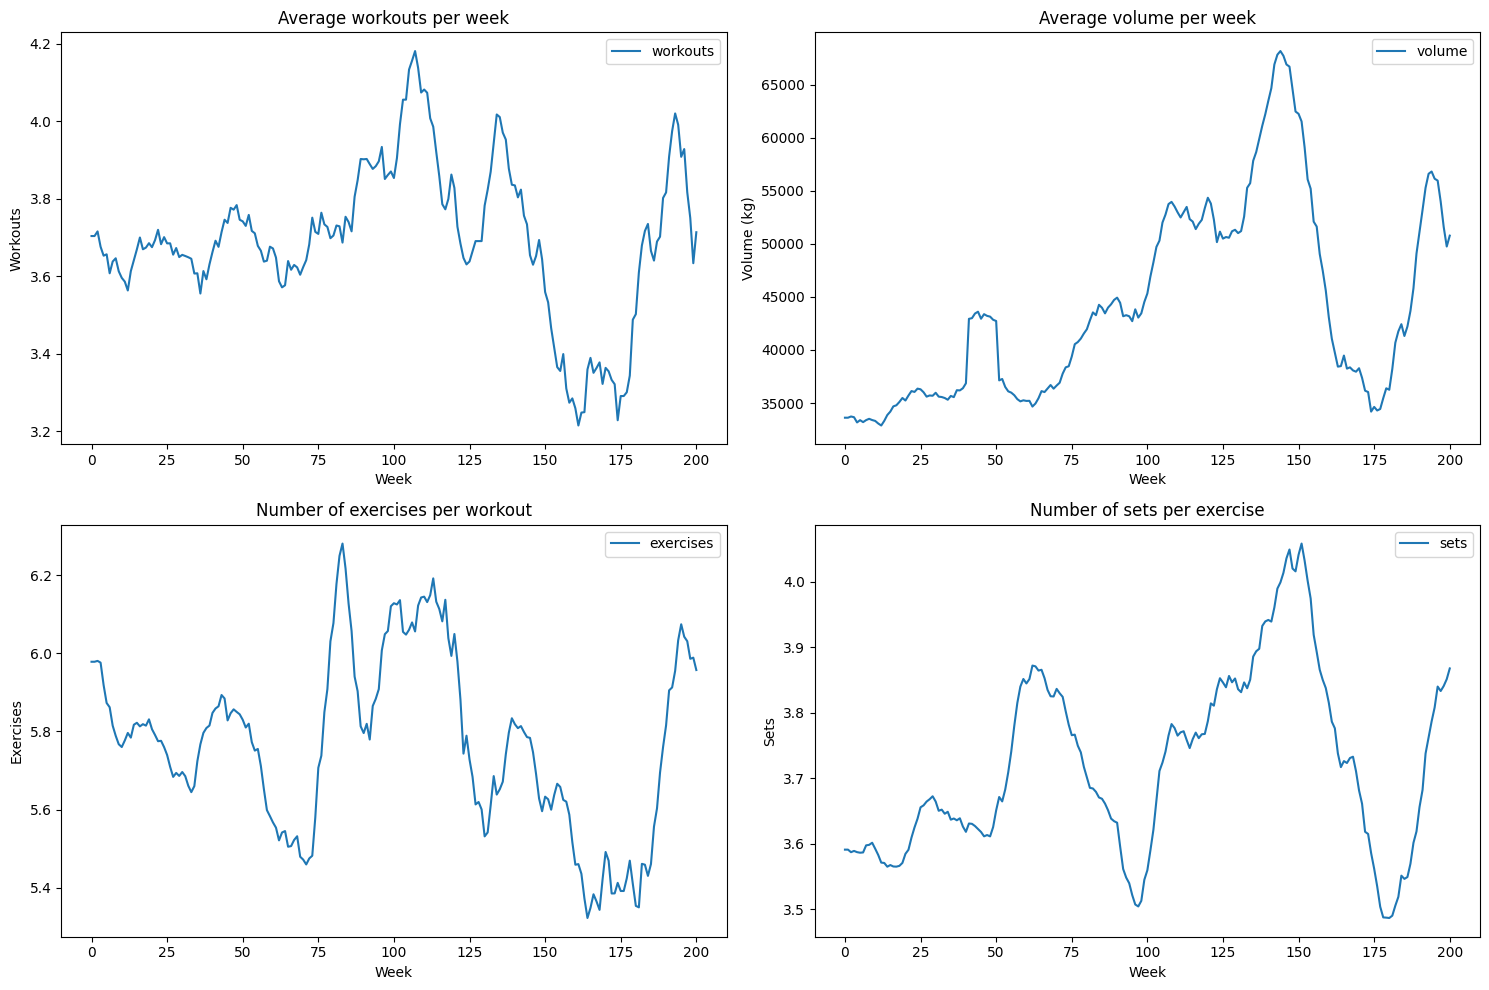

In [16]:
# plot all together
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
df0.plot(ax=ax[0, 0])
df1.plot(ax=ax[0, 1])
df2.plot(ax=ax[1, 0])
df3.plot(ax=ax[1, 1])
ax[0, 0].set_title('Average workouts per week')
ax[0, 0].set_xlabel('Week')
ax[0, 0].set_ylabel('Workouts')
ax[0, 1].set_title('Average volume per week')
ax[0, 1].set_xlabel('Week')
ax[0, 1].set_ylabel('Volume (kg)')
ax[1, 0].set_title('Number of exercises per workout')
ax[1, 0].set_xlabel('Week')
ax[1, 0].set_ylabel('Exercises')
ax[1, 1].set_title('Number of sets per exercise')
ax[1, 1].set_xlabel('Week')
ax[1, 1].set_ylabel('Sets')
plt.tight_layout()
plt.savefig('../Plot/workout_stats.pdf')
plt.show()

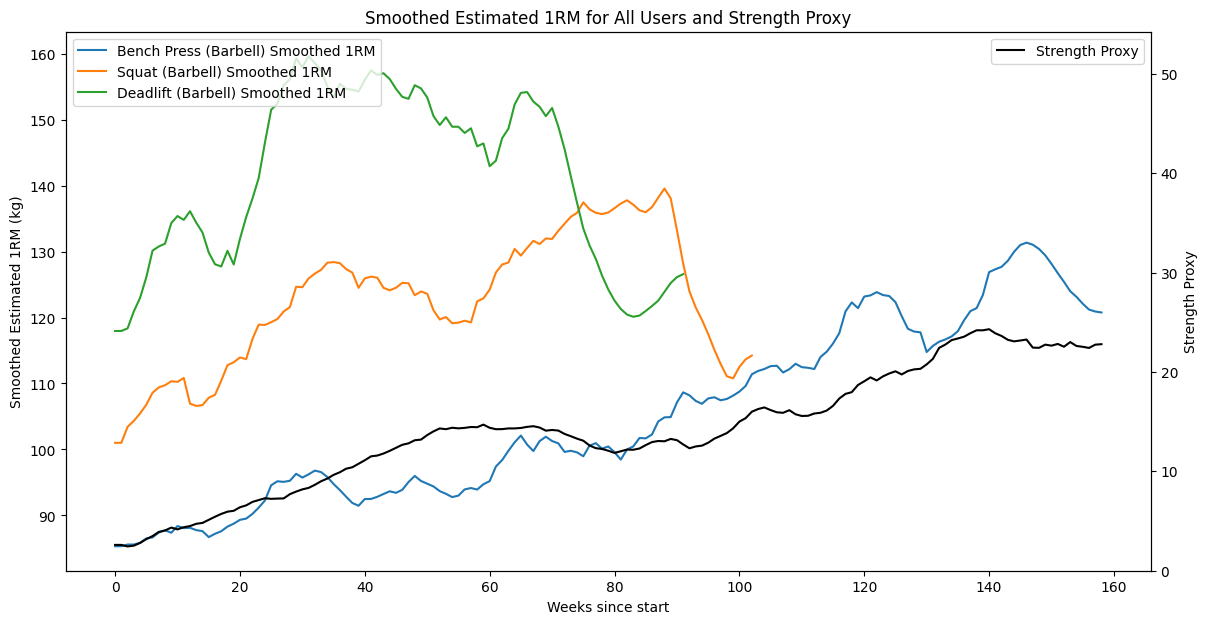

In [17]:
import os
import glob
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

df = pd.read_csv("../Data/workout_data.csv")

strength_diffs_df = pd.read_csv("../Data/strength_diffs.csv")


# Define exercises of interest
exercise_names = ["Bench Press (Barbell)", "Squat (Barbell)", "Deadlift (Barbell)"]
df = df[df['exercise_title'].isin(exercise_names)]

df = df.groupby(['username', 'week', 'exercise_title']).agg({'estimated_1rm': 'max'}).reset_index()

# Group by weeks_since_start and exercise_title and calculate mean and std
df = df.groupby(['week', 'exercise_title']).agg({'estimated_1rm':'mean', 'username':'nunique'}).reset_index()

# filter: at least five users, all exercises available
df = df[df['username'] >= 5]
df.drop(columns='username', inplace=True)

# # add strength proxy
# df = df.merge(strength_diffs_df, on=['username', 'week'], how='left')

# Plot the smoothed estimates of 1RM with confidence bounds and strength proxy
fig, ax1 = plt.subplots(figsize=(14, 7))

max_week = 0
for exercise in exercise_names:
    exercise_subset = df[df['exercise_title'] == exercise]
    # interpolate missing weeks
    exercise_subset = exercise_subset.set_index('week').reindex(range(exercise_subset['week'].min(), exercise_subset['week'].max() + 1)).reset_index()
    exercise_subset['estimated_1rm'] = exercise_subset['estimated_1rm'].interpolate()
    
    # smooth the estimated 1RM
    exercise_subset['estimated_1rm'] = smooth_series(exercise_subset['estimated_1rm'], kernel_size=10)
    ax1.plot(exercise_subset['week'], exercise_subset['estimated_1rm'], label=f"{exercise} Smoothed 1RM")
    
    max_week = max(max_week, exercise_subset['week'].max())
    
# Create a second y-axis for the strength proxy
ax2 = ax1.twinx()

# # plot strength proxy
strength_diffs_df = strength_diffs_df[strength_diffs_df['week'] <= max_week]

# cumsum for all users and find the end value of the strongest user
groups = strength_diffs_df.groupby('username')
strongest_user = 0
for user, group in groups:
    group['d_strength'] = group['d_strength'].cumsum()
    assert group['week'].is_monotonic_increasing
    strongest_user = max(strongest_user, group['d_strength'].iloc[-1])

strength_diffs_df = strength_diffs_df.groupby('week').agg({'d_strength': 'mean'}).reset_index()
strength_diffs_df['d_strength'] = strength_diffs_df['d_strength'].cumsum()
strength_diffs_df['d_strength'] = smooth_series(strength_diffs_df['d_strength'], kernel_size=10)
ax2.plot(strength_diffs_df['week'], strength_diffs_df['d_strength'], label='Strength Proxy', color='black')
ax2.set_ylim(0, strongest_user)
ax2.set_ylabel('Strength Proxy')

ax1.set_xlabel('Weeks since start')
ax1.set_ylabel('Smoothed Estimated 1RM (kg)')
ax1.legend(loc='upper left')

plt.legend()
plt.title('Smoothed Estimated 1RM for All Users and Strength Proxy')
plt.savefig('../Plot/estimated_1rm.pdf')
plt.show()

# Autocorrelation for each user
Step 1: remove weights

See how consistent an athlete shows up and how they stick to a program

In [18]:
df = pd.read_csv("../Data/workout_data.csv")
keep_columns = ['username', 'week', 'exercise_title', 'set_index', 'reps', 'workout_id','start_time','end_time','exercise_title',
                'superset_id','set_index','set_type','muscle_group','exercise_type','other_muscles','equipment',
                'set_id','days_since_start','week']
df = df[keep_columns]

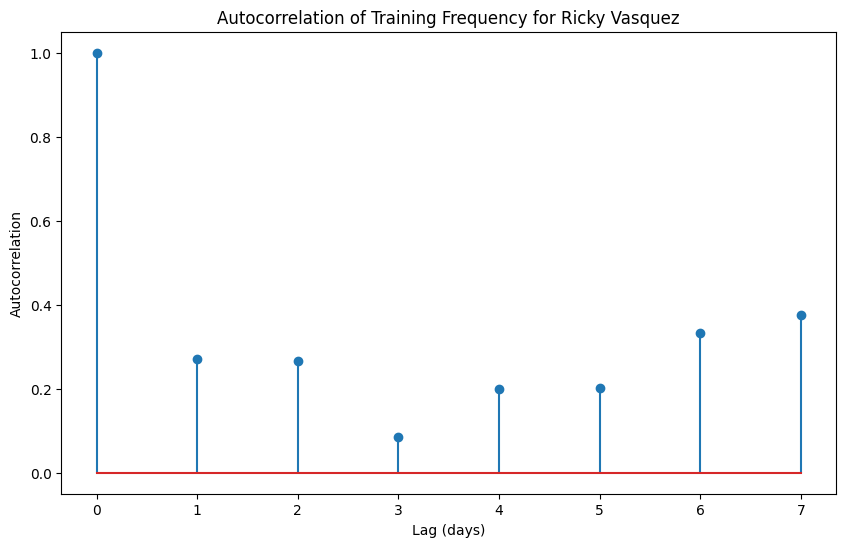

Ricky Vasquez: [1.         0.27034098 0.26548427 0.08620145 0.1992649  0.20113356
 0.33365284 0.37628141]


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf

# Load data
df = pd.read_csv("../Data/workout_data.csv")

# Define the columns to keep
keep_columns = ['username', 'days_since_start', 'exercise_title', 'set_index', 'reps', 'workout_id', 'start_time', 'end_time', 
                'exercise_title', 'superset_id', 'set_index', 'set_type', 'muscle_group', 'exercise_type', 
                'other_muscles', 'equipment', 'set_id']
df = df[keep_columns]

# Ensure 'days_since_start' column is treated as integer
df['days_since_start'] = df['days_since_start'].astype(int)

# Function to calculate daily training frequency for each user
def calculate_daily_frequency(df):
    daily_frequency = df.groupby(['username', 'days_since_start']).size().reset_index(name='frequency')
    return daily_frequency

# Function to calculate autocorrelation for each user
def calculate_autocorrelation(df):
    users = df['username'].unique()
    autocorrelations = {}
    
    for user in users:
        user_data = df[df['username'] == user]
        daily_frequency = calculate_daily_frequency(user_data)
        
        # Ensure there are no missing days
        all_days = pd.DataFrame({'days_since_start': range(daily_frequency['days_since_start'].min(), daily_frequency['days_since_start'].max() + 1)})
        daily_frequency = all_days.merge(daily_frequency, how='left', on='days_since_start').fillna(0)
        
        # Calculate autocorrelation
        autocorr = acf(daily_frequency['frequency'], nlags=7)  # 365 days in a year
        autocorrelations[user] = autocorr
        
        # Plot autocorrelation
        plt.figure(figsize=(10, 6))
        plt.stem(autocorr)
        plt.title(f'Autocorrelation of Training Frequency for {user}')
        plt.xlabel('Lag (days)')
        plt.ylabel('Autocorrelation')
        plt.show()
        break
    
    return autocorrelations

# Perform autocorrelation analysis
autocorrelations = calculate_autocorrelation(df)

# Display the autocorrelation values
for user, autocorr in autocorrelations.items():
    print(f'{user}: {autocorr}')


Correlation between best bench press 1RM and training frequency autocorrelation: -0.2013


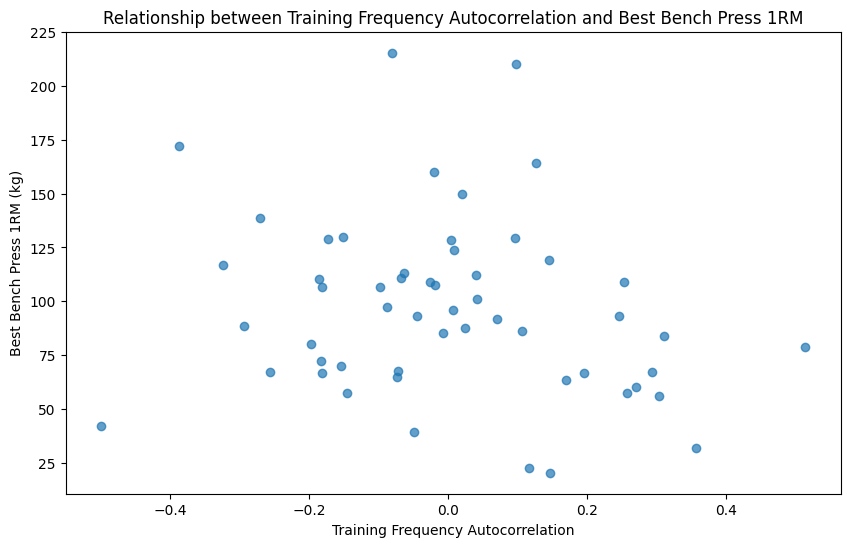

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf

# Load data
df = pd.read_csv("../Data/workout_data.csv")

# Extract the best 1RM for bench press for each user
bench_press_df = df[df['exercise_title'] == 'Bench Press (Barbell)']
best_1rm = bench_press_df.groupby('username')['estimated_1rm'].max().reset_index()
best_1rm.columns = ['username', 'best_bench_press_1rm']

# Function to calculate daily training frequency for each user
def calculate_daily_frequency(df):
    daily_frequency = df.groupby(['username', 'days_since_start']).size().reset_index(name='frequency')
    return daily_frequency

# Function to calculate autocorrelation for each user
def calculate_autocorrelation(df):
    users = df['username'].unique()
    autocorrelations = {}
    
    for user in users:
        user_data = df[df['username'] == user]
        daily_frequency = calculate_daily_frequency(user_data)
        
        # Ensure there are no missing days
        all_days = pd.DataFrame({'days_since_start': range(daily_frequency['days_since_start'].min(), daily_frequency['days_since_start'].max() + 1)})
        daily_frequency = all_days.merge(daily_frequency, how='left', on='days_since_start').fillna(0)
        
        # Calculate autocorrelation
        autocorr = acf(daily_frequency['frequency'], nlags=365)  # 365 days in a year
        autocorrelations[user] = autocorr[1]  # Using lag 1 autocorrelation
        
    return autocorrelations

# Perform autocorrelation analysis
autocorrelations = calculate_autocorrelation(df)

# Convert autocorrelations to DataFrame
autocorr_df = pd.DataFrame(list(autocorrelations.items()), columns=['username', 'autocorrelation'])

# Merge best 1RM and autocorrelation DataFrames
merged_df = pd.merge(best_1rm, autocorr_df, on='username')

# Calculate correlation
correlation = merged_df['best_bench_press_1rm'].corr(merged_df['autocorrelation'])
print(f'Correlation between best bench press 1RM and training frequency autocorrelation: {correlation:.4f}')

# Plot the relationship
plt.figure(figsize=(10, 6))
plt.scatter(merged_df['autocorrelation'], merged_df['best_bench_press_1rm'], alpha=0.7)
plt.xlabel('Training Frequency Autocorrelation')
plt.ylabel('Best Bench Press 1RM (kg)')
plt.title('Relationship between Training Frequency Autocorrelation and Best Bench Press 1RM')
plt.show()
